# Laboratorio: Analizando el tipo de cambio USD-EUR

<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
</center>
<i>Creado:     2022-Ago-21 
    <br>
 Actualizado: 2025-Ago-08</i>

En este cuaderno de Jupyter se ilustran varios de los conceptos del **Tema 1: Introducción al análisis de series de tiempo**.

## 1. Importar los paquetes necesarios para este ejemplo

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats.distributions import chi2
import os

En este bloque controlamos las propiedades de las figuras

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-talk')
plt.rc('figure', figsize=[12, 5])
plt.rc('savefig', bbox='tight', transparent=True)
figpath = "../figures/"
SAVEFIGS = True  # Cambiar a False si no se quieren guardar las figuras


años_ticks = [pd.Period(f'{año}', freq='D') for año in np.arange(2000,2025,5)]     
años_ticklabels = [año.year for año in años_ticks] 

## 2. Descargar los datos

Usamos `pandas.read_xml` para descargar los datos en formato XML desde Internet.

In [3]:
euro = pd.read_xml("https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/usd.xml", 
                   xpath='.//xsi:Obs', 
                   attrs_only=True, 
                   namespaces={'xsi':"http://www.ecb.europa.eu/vocabulary/stats/exr/1"})
euro.index = pd.to_datetime(euro['TIME_PERIOD'])  # convertir esta columna a fechas
euro.index = euro.index.to_period('D') #indexar como datos dirios
euro.index.name=''  # quitar nombre para que no aparezca en los gráficos
euro = euro['OBS_VALUE']

## 3. Graficar la serie de tiempo, en distintas versiones

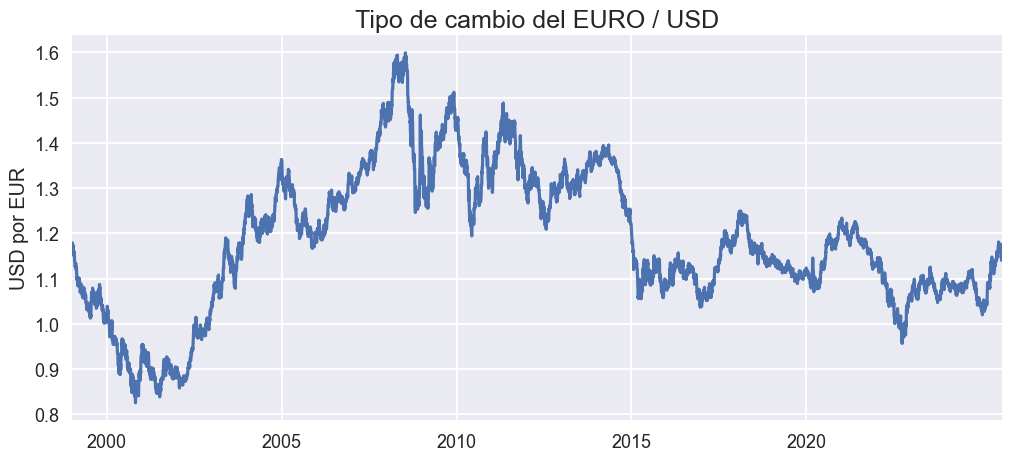

In [4]:
fig, ax = plt.subplots()
euro.plot(ax=ax, legend=None)
ax.set_title("Tipo de cambio del EURO / USD", fontsize=18)
ax.set(xticks=años_ticks, 
       xticklabels=años_ticklabels,
       ylabel='USD por EUR')

if SAVEFIGS:
    fig.savefig(figpath + "ej-euro-nivel.png")

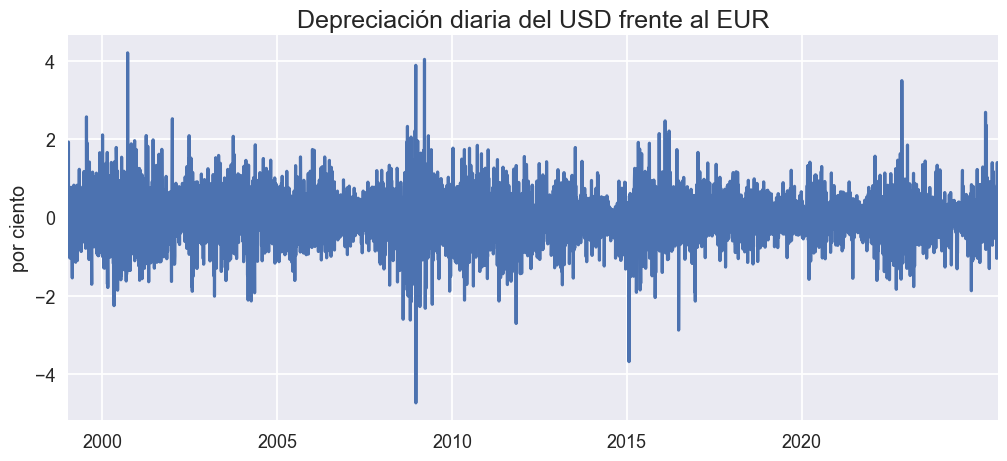

In [5]:
leuro = np.log(euro)

Dleuro = 100* leuro.diff().dropna()
Dleuro2 = leuro.diff().dropna()**2

fig, ax = plt.subplots()
Dleuro.plot(ax=ax, legend=None)
ax.set_title("Depreciación diaria del USD frente al EUR", fontsize=18)
ax.set(ylabel='por ciento',
       xticks=años_ticks, 
       xticklabels=años_ticklabels)

if SAVEFIGS:
       fig.savefig(figpath + "ej-euro-depreciacion.png")

## 4. Analizar el autocorrelograma y el autocorrelograma parcial

Primeros definimos unas opciones para los gráficos. Además, definimos `plot_acf` y  `plot_pacf` como las respectivas funciones de `statsmodels`, para que sea más fácil de digitar abajo (para no tener que escribir `sm.graphics.tsa.` a cada rato!).

In [6]:
OPCIONES = dict(lags=48, alpha=0.05, zero=False, missing='drop')
plot_acf = sm.graphics.tsa.plot_acf
plot_pacf = sm.graphics.tsa.plot_pacf

Presentamos tres autocorrelogramas:

- la serie en nivel (log), $\ln(y_t)$: vemos que las correlaciones disminuyen muy lentamente, lo cual es típico de una serie que tiene una tendencia marcada.
- la tasa de crecimiento diaria, $\ln(y_t) - \ln(y_{t-1})$: aparentemente es prácticamente ruido blanco. 
- el cuadrado de la tasa de crecimiento diaria, $(\ln(y_t) - \ln(y_{t-1}))^2$: esto es una medida de volatilidad: vemos que la volatilidad es sumamente persistente.

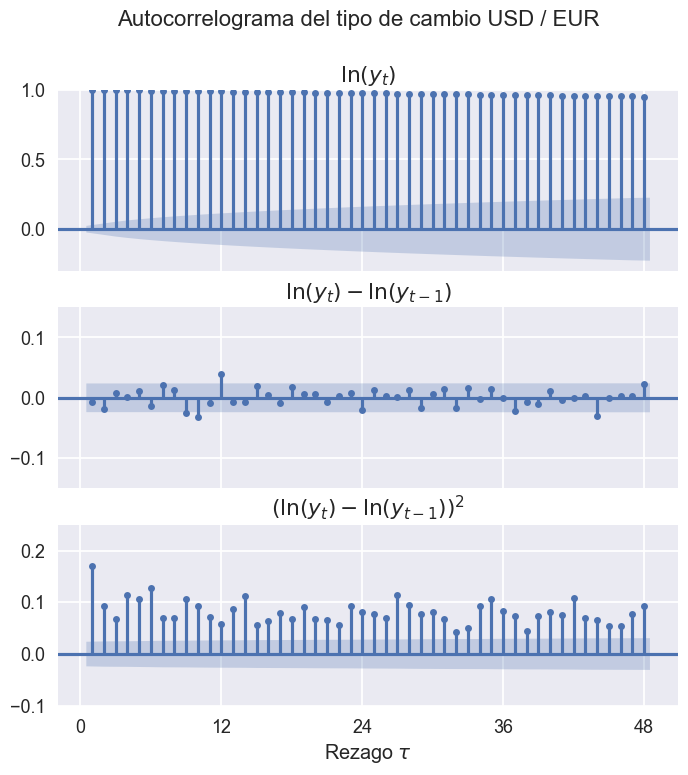

In [7]:
fig, axs = plt.subplots(3,1, figsize=[8,8], sharex=True)

plot_acf(leuro, ax=axs[0], title=r'$\ln(y_t)$', **OPCIONES);
plot_acf(Dleuro, ax=axs[1], title=r'$\ln(y_t) - \ln(y_{t-1})$', **OPCIONES);
plot_acf(Dleuro2, ax=axs[2], title=r'$(\ln(y_t) - \ln(y_{t-1}))^2$', **OPCIONES);

axs[2].set_xlabel(r'Rezago $\tau$')
axs[2].set_xticks(np.arange(0,49,12));
axs[0].set_ylim(-0.3, 1.0)
axs[1].set_ylim(-0.15, 0.15)
axs[2].set_ylim(-0.1, 0.25)

fig.suptitle('Autocorrelograma del tipo de cambio USD / EUR', size=16)

if SAVEFIGS:
    fig.savefig(figpath + "ej-euro-acf.png")

Presentamos tres autocorrelogramas parciales:

- la serie en nivel (log), $\ln(y_t)$: solo el primer rezago es significativo, lo cual es típico de una serie de caminata aleatoria (lo estudiamos más adelante ene l curso).
- la tasa de crecimiento diaria, $\ln(y_t) - \ln(y_{t-1})$: de nuevo, aparentemente es prácticamente ruido blanco. 
- el cuadrado de la tasa de crecimiento diaria, $(\ln(y_t) - \ln(y_{t-1}))^2$: de nuevo vemos que la volatilidad es sumamente persistente.

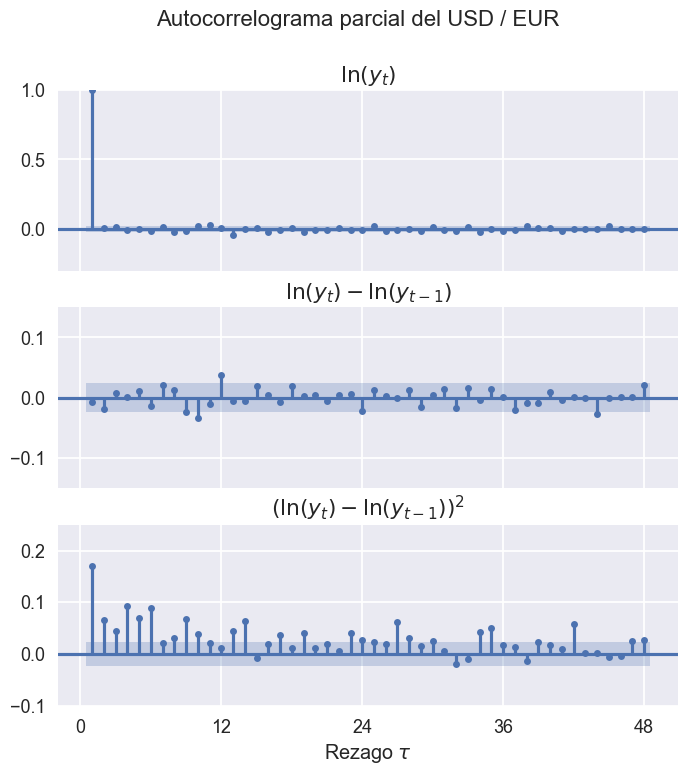

In [8]:
fig, axs = plt.subplots(3,1, figsize=[8,8], sharex=True)


OPCIONES2 = dict(lags=48, alpha=0.05, method='ols', zero=False)

plot_pacf(leuro, ax=axs[0], title=r'$\ln(y_t)$', **OPCIONES2);
plot_pacf(Dleuro, ax=axs[1], title=r'$\ln(y_t) - \ln(y_{t-1})$', **OPCIONES2);
plot_pacf(Dleuro2, ax=axs[2], title=r'$(\ln(y_t) - \ln(y_{t-1}))^2$', **OPCIONES2);

axs[2].set(xlabel=r'Rezago $\tau$',
           xticks=np.arange(0,49,12))
axs[0].set_ylim(-0.3, 1.0)
axs[1].set_ylim(-0.15, 0.15)
axs[2].set_ylim(-0.1, 0.25)

fig.suptitle('Autocorrelograma parcial del USD / EUR', size=16)

if SAVEFIGS:
    fig.savefig(figpath + "ej-euro-pacf.png")  

## 5. Pruebas de ruido blanco

Definimos algunos parámetros necesarios para realizar las pruebas de hipótesis

In [9]:
T = Dleuro.size  # número de datos
M = 12   # máximo número de rezagos
rezagos = np.arange(1, M+1)
alpha = 0.05  # significancia de los test

### Box-Pierce y Ljung-Box
**Statsmodels** no da los resultados de las pruebas en un formato particulamente útil; por ello definimos la función `estadísticos` para tener ordenados nuestros resultados en una tabla de **pandas**. $\chi^2$

In [10]:
def estadisticos(serie, nlags=12, alpha=0.05):
    # serie = la serie de tiempo para la prueba
    # nlags = máximo número de rezagos que se calculará
    # alpha = nivel de significancia para la prueba 𝜒2

    rezagos = np.arange(1, nlags+1)
    T = serie.size  # número de observaciones

    # Definimos el dataframe, pero sin datos aún. Las columnas son los estadísticos y las filas los distintos rezagos
    df = pd.DataFrame(columns=['AC', 'PAC', 'Q*', 'Q', '𝜒2'], index=rezagos) 
    
    # en estas dos líneas el término  "[1:]" es para no incluir el rezago 0, que siempre es igual a 1.0
    df['AC'] = sm.tsa.acf(serie, fft=True, nlags=nlags)[1:] # autocorrelaciones
    df['PAC'] = sm.tsa.pacf(serie, nlags=nlags, method='ols')[1:] # autocorrelaciones parciales
    
    # Ver páginas 55 y 56 de los apuntes de clase. La idea con cumsum es para hacer la prueba con distintos valores de "m"
    df['Q*'] = T * (df['AC'] ** 2).cumsum() # test de Box-Pierce
    df['Q'] = T * (T+2) * ((df['AC'] ** 2)/(T-rezagos)).cumsum() # test de Ljung-Box
    df['𝜒2'] = np.array([chi2(m).ppf(1-alpha) for m in rezagos]) # valores críticos 𝜒2 con "m" grados de libertad

    df.index.name = 'Rezagos'
    return df

Al evaluar la depreciación diaria del dólar frente al euro, casi todos los estadísticos Q son menores que los valores críticos: no podemos rechazar que la serie sea ruido blanco.

In [11]:
estadisticos(Dleuro).round(4)

,AC,PAC,Q*,Q,𝜒2
Rezagos,,,,,
1,-0.0063,-0.0063,0.2692,0.2693,3.8415
2,-0.0187,-0.0187,2.6504,2.6519,5.9915
3,0.0084,0.0081,3.1260,3.1279,7.8147
4,0.0012,0.0010,3.1364,3.1382,9.4877
5,0.0111,0.0114,3.9774,3.9802,11.0705
6,-0.0133,-0.0132,5.1845,5.1887,12.5916
7,0.0210,0.0213,8.1987,8.2068,14.0671
8,0.0128,0.0124,9.3095,9.3192,15.5073
9,-0.0246,-0.0236,13.4435,13.4600,16.9190


Pero al evaluar la volatilidad de la serie, los estadísticos Q siempre son mayores que los valores críticos: la volatilidad del tipo de cambio no es ruido blanco.

In [12]:
estadisticos(Dleuro2).round(4)

,AC,PAC,Q*,Q,𝜒2
Rezagos,,,,,
1,0.1695,0.1695,195.6492,195.7353,3.8415
2,0.0935,0.0667,255.1724,255.2936,5.9915
3,0.0684,0.0438,287.0463,287.1909,7.8147
4,0.1135,0.0932,374.8450,375.0670,9.4877
5,0.1060,0.0696,451.3995,451.7002,11.0705
6,0.1280,0.0898,562.9109,563.3426,12.5916
7,0.0703,0.0204,596.5340,597.0102,14.0671
8,0.0705,0.0305,630.3575,630.8834,15.5073
9,0.1061,0.0683,707.0933,707.7434,16.9190


Esta línea de código une las dos tablas anteriores en una sola, redondea los datos a 2 decimales, y exporta el resultado a un archivo de LaTeX.

In [13]:
if SAVEFIGS:       
    (pd.concat([estadisticos(Dleuro), estadisticos(Dleuro2)],
            axis=1, 
            keys=['Depreciación diaria', 'Cuadrado de la depreciación diaria'])
    .style
    .format(precision=2)
    .to_latex(figpath+'ej-euro-tabla.tex', 
            hrules=True, 
            column_format='|l|rrrrr|rrrrr|', 
            multicol_align='c')
    )         

### Durbin-Watson
Realizamos la prueba Durbin-Watson a la depreciación diaria: el valor tan cercano a dos nos indica que no hay autocorrelación de primer orden en esta serie.

In [14]:
sm.stats.stattools.durbin_watson(Dleuro)

np.float64(2.0125729935606578)

Acá calculamos de nuevo el estadístico Durbin Watson, pero esta vez sin usar **statsmodels**.

In [15]:
(Dleuro.diff()**2).sum() / (Dleuro**2).sum() # ver p.57 apuntes de clase

np.float64(2.0125729935606578)

### Jarque-Bera

In [16]:
from scipy.stats import norm


De nuevo, hacemos una función auxiliar para interpretar más fácilmente los resultados que obtenemos con *Statsmodels*

In [17]:
def JarqueBera(serie):
    return pd.Series(sm.stats.stattools.jarque_bera(serie), 
                     index=['Jarque Bera','pvalue','Asimetría', 'Kurtosis']).astype(float)

In [18]:
jb = JarqueBera(Dleuro)
jb

Jarque Bera    2926.123581
pvalue            0.000000
Asimetría         0.043039
Kurtosis          6.209892
dtype: float64

El p-value es prácticamente cero: la serie no tiene una distribución normal.

Abajo ilustramos este punto con un histograma de la serie, a la cual le superponemos la distribución normal que tiene la misma media y variaza que los datos.

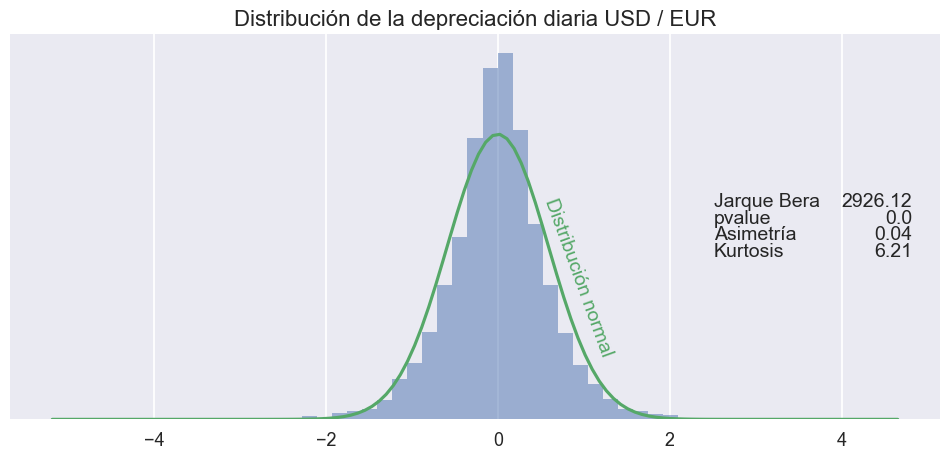

In [19]:
fig, ax = plt.subplots()

# dibujamos el histograma
Dleuro.hist(ax=ax, bins=51, alpha=0.5, density=True)
xmin, xmax = ax.get_xlim()


# superponemos la distribución normal
x = np.linspace(xmin, xmax, 120)
p = norm.pdf(x, *norm.fit(Dleuro))
ax.plot(x, p)
ax.annotate('Distribución normal', (x[74], p[75]), color='C1', rotation=-70, ha='center', fontsize=14)

# table es para escribir una pequeña tabla de valores a la derecha del gráfico
table = ax.table(cellText=jb.round(2).values.reshape(4,1), 
         rowLabels=jb.index, 
         edges='',
         loc='center right',
         colWidths=[0.1,0.1],
         zorder=1)

table.set_fontsize(14)

ax.set_title('Distribución de la depreciación diaria USD / EUR', fontsize=16)
ax.set_yticks([])

if SAVEFIGS:
    fig.savefig(figpath + "ej-euro-histograma.png")